In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightkurve as lk
import time
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock


In [19]:
# Lock for thread-safe printing
print_lock = Lock()

def get_lightcurve_info(row_data):
    """Get sector info for a single TIC - designed for parallel processing"""
    i, tic_id, st_tmag, st_rad, st_mass, st_teff = row_data
    tic_str = f"TIC {int(tic_id)}"
    
    try:
        lc_collection = lk.search_lightcurve(tic_str, mission="TESS", author="TESS-SPOC", cadence="long").mission
        if lc_collection is not None:
            sector_length = len(lc_collection)
            with print_lock:
                print(f'{i} tic {tic_str}: sector length {sector_length}, tmag {st_tmag}, rad {st_rad}, mass {st_mass}, teff {st_teff}')
                
            return {
                'id': tic_id,
                'tmag': st_tmag,
                'RAD': st_rad,
                'MASS': st_mass,
                'teff': st_teff,
                'sector_length': sector_length
            }
        else:
            with print_lock:
                print(f'{i} tic {tic_str}: No data found')
            return {
                'id': tic_id,
                'tmag': st_tmag,
                'RAD': st_rad,
                'MASS': st_mass,
                'teff': st_teff,
                'sector_length': np.nan
            }
    except Exception as e:
        with print_lock:
            print(f"Error processing {tic_str}: {e}")
        return {
            'id': tic_id,
            'tmag': st_tmag,
            'RAD': st_rad,
            'MASS': st_mass,
            'teff': st_teff,
            'sector_length': np.nan
        }

# Load and deduplicate data
star_params = pd.read_csv("stellar_params_CTL.csv")
# star_params = star_params[star_params['tmag'] < 13]
# star_params = star_params[star_params['teff'] > 3000]
# star_params = star_params[star_params['teff'] < 7000]
#print(star_params)
#print(f"Max st_teff: {star_params['st_teff'].max()}")
star_params = star_params[0:100]  # Process only first 100 rows for testing
print(f"Original rows: {len(star_params)}")

# Remove duplicates based on TIC ID - keep first occurrence
star_params_unique = star_params.drop_duplicates(subset=['id'], keep='first').reset_index(drop=True)
print(f"After deduplication: {len(star_params_unique)}")
print(f"Duplicates removed: {len(star_params) - len(star_params_unique)}\n")

# Load existing results to skip already processed TICs
output_file = "saved_sectors_info_CTL.csv"
if os.path.exists(output_file):
    existing_results = pd.read_csv(output_file)
    processed_tics = set(existing_results['id'].values)
    print(processed_tics)
    print(f"Found {len(processed_tics)} already processed TICs\n")
else:
    existing_results = pd.DataFrame()
    processed_tics = set()

# Start timing
start_time = time.time()
print(f"Starting processing at {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total stars to process: {len(star_params_unique)}\n")

# Prepare data for parallel processing - skip already processed TICs
row_data_list = [
    (i, row['id'], row['tmag'], row['RAD'], row['MASS'], row['teff'])
    for i, row in star_params_unique.iterrows()
    if int(row['id']) not in processed_tics
]

print(f"Skipping {len(star_params_unique) - len(row_data_list)} already processed TICs")
print(f"Processing {len(row_data_list)} new TICs\n")

# Parallel processing with ThreadPoolExecutor
# Use max_workers based on your system - typically 10-20 for I/O-bound tasks
max_workers = 10  # Adjust this based on your system and network bandwidth
results_list = []

print(f"Using {max_workers} parallel workers\n")

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks
    future_to_row = {executor.submit(get_lightcurve_info, row_data): row_data for row_data in row_data_list}
    
    # Collect results as they complete
    completed = 0
    for future in as_completed(future_to_row):
        result = future.result()
        results_list.append(result)
        completed += 1
        
        # Progress update every 10 stars
        if completed % 10 == 0:
            elapsed = time.time() - start_time
            rate = completed / elapsed
            remaining = len(row_data_list) - completed
            eta = remaining / rate if rate > 0 else 0
            with print_lock:
                print(f"\nProgress: {completed}/{len(row_data_list)} ({100*completed/len(row_data_list):.1f}%) - ETA: {eta/60:.1f} min\n")

# Combine new results with existing ones
if len(results_list) > 0:
    CTL_sectors = pd.concat([existing_results, pd.DataFrame(results_list)], ignore_index=True)
    CTL_sectors.to_csv(output_file, index=False)
    print(f"\nSaved {len(results_list)} new results ({len(CTL_sectors)} total) to {output_file}")
else:
    CTL_sectors = existing_results
    print(f"\nNo new results to save")

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\n{'='*60}")
print(f"Processing complete!")
print(f"Total time elapsed: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
if len(row_data_list) > 0:
    print(f"Average time per star: {elapsed_time/len(row_data_list):.2f} seconds")
    print(f"Processing rate: {len(row_data_list)/elapsed_time:.2f} stars/second")
print(f"Finished at {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*60}")

Original rows: 100
After deduplication: 88
Duplicates removed: 12

{437041669.0, 25823239.0, 13145616.0, 367631380.0, 120526877.0, 115117598.0, 25374751.0, 200322593.0, 287291938.0, 262539812.0, 122574885.0, 284701226.0, 70503467.0, 273551414.0, 391454774.0, 79287361.0, 323959890.0, 323196001.0, 32811633.0, 377862259.0, 331930750.0, 92994182.0, 149598862.0, 46641297.0, 293117088.0, 207339173.0, 437063338.0, 173095595.0, 219119821.0, 279314127.0, 156495056.0, 15552721.0, 166933207.0, 297823453.0, 100800733.0, 39564511.0, 25192164.0, 417838312.0, 262722802.0, 47163636.0, 13135619.0, 124815110.0, 10686217.0, 158235404.0, 121947405.0, 24292625.0, 415085843.0, 233975064.0, 160083748.0, 77479212.0, 243800364.0, 288314668.0, 262325558.0, 307520312.0, 123368775.0, 143209292.0, 16773461.0, 283410775.0, 239754073.0, 252699482.0, 231459697.0, 344569203.0, 91131262.0, 156619134.0, 16530308.0, 256364937.0, 160329609.0, 447382925.0, 273864083.0, 61258139.0, 229878187.0, 387585453.0, 316134320.0, 477

In [21]:
# Load and deduplicate data
star_params = pd.read_csv("TOI_Mar2025_1pt5to4_R.csv")
# star_params = star_params[star_params['tmag'] < 13]
# star_params = star_params[star_params['teff'] > 3000]
# star_params = star_params[star_params['teff'] < 7000]
#print(star_params)
#print(f"Max st_teff: {star_params['st_teff'].max()}")
star_params = star_params[0:100]  # Process only first 100 rows for testing
print(f"Original rows: {len(star_params)}")

# Remove duplicates based on TIC ID - keep first occurrence
star_params_unique = star_params.drop_duplicates(subset=['tid'], keep='first').reset_index(drop=True)
print(f"After deduplication: {len(star_params_unique)}")
print(f"Duplicates removed: {len(star_params) - len(star_params_unique)}\n")

# Load existing results to skip already processed TICs
output_file = "saved_sectors_info_TOI.csv"
if os.path.exists(output_file):
    existing_results = pd.read_csv(output_file)
    processed_tics = set(existing_results['id'].values)
    print(f"Found {len(processed_tics)} already processed TICs\n")
else:
    existing_results = pd.DataFrame()
    processed_tics = set()

# Start timing
start_time = time.time()
print(f"Starting processing at {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total stars to process: {len(star_params_unique)}\n")

# Prepare data for parallel processing - skip already processed TICs
row_data_list = [
    # Insert a placeholder mass (np.nan) because TOI list has no mass column
    (i, row['tid'], row['st_tmag'], row['st_rad'], np.nan, row['st_teff'])
    for i, row in star_params_unique.iterrows()
    if f"TIC {int(row['tid'])}" not in processed_tics
]

print(f"Skipping {len(star_params_unique) - len(row_data_list)} already processed TICs")
print(f"Processing {len(row_data_list)} new TICs\n")

# Parallel processing with ThreadPoolExecutor
# Use max_workers based on your system - typically 10-20 for I/O-bound tasks
max_workers = 10  # Adjust this based on your system and network bandwidth
results_list = []

print(f"Using {max_workers} parallel workers\n")

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks
    future_to_row = {executor.submit(get_lightcurve_info, row_data): row_data for row_data in row_data_list}
    
    # Collect results as they complete
    completed = 0
    for future in as_completed(future_to_row):
        result = future.result()
        results_list.append(result)
        completed += 1
        
        # Progress update every 10 stars
        if completed % 10 == 0:
            elapsed = time.time() - start_time
            rate = completed / elapsed
            remaining = len(row_data_list) - completed
            eta = remaining / rate if rate > 0 else 0
            with print_lock:
                print(f"\nProgress: {completed}/{len(row_data_list)} ({100*completed/len(row_data_list):.1f}%) - ETA: {eta/60:.1f} min\n")

# Combine new results with existing ones
if len(results_list) > 0:
    CTL_sectors = pd.concat([existing_results, pd.DataFrame(results_list)], ignore_index=True)
    CTL_sectors.to_csv(output_file, index=False)
    print(f"\nSaved {len(results_list)} new results ({len(CTL_sectors)} total) to {output_file}")
else:
    CTL_sectors = existing_results
    print(f"\nNo new results to save")

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\n{'='*60}")
print(f"Processing complete!")
print(f"Total time elapsed: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
if len(row_data_list) > 0:
    print(f"Average time per star: {elapsed_time/len(row_data_list):.2f} seconds")
    print(f"Processing rate: {len(row_data_list)/elapsed_time:.2f} stars/second")
print(f"Finished at {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*60}")

Original rows: 100
After deduplication: 96
Duplicates removed: 4

Starting processing at 2025-11-19 16:38:26
Total stars to process: 96

Skipping 0 already processed TICs
Processing 96 new TICs

Using 10 parallel workers

1 tic TIC 119292328: sector length 4, tmag 8.9767, rad 0.882675, mass nan, teff 5581.0
1 tic TIC 119292328: sector length 4, tmag 8.9767, rad 0.882675, mass nan, teff 5581.0
3 tic TIC 443823169: sector length 5, tmag 11.6627, rad 0.296806, mass nan, teff 3261.0
6 tic TIC 421006834: sector length 4, tmag 12.5437, rad 0.37, mass nan, teff 3338.0
3 tic TIC 443823169: sector length 5, tmag 11.6627, rad 0.296806, mass nan, teff 3261.0
6 tic TIC 421006834: sector length 4, tmag 12.5437, rad 0.37, mass nan, teff 3338.0
7 tic TIC 421005422: sector length 1, tmag 10.7077, rad 0.76, mass nan, teff 5181.1
7 tic TIC 421005422: sector length 1, tmag 10.7077, rad 0.76, mass nan, teff 5181.1
0 tic TIC 349986198: sector length 2, tmag 12.5389, rad 0.87, mass nan, teff 4642.1
0 tic TI

No data found for target "TIC 96475638".


21 tic TIC 337217173: sector length 3, tmag 11.5546, rad 0.25, mass nan, teff 3236.0
Error processing TIC 96475638: 'mission'

Progress: 20/96 (20.8%) - ETA: 0.7 min

23 tic TIC 368628986: sector length 2, tmag 9.57157, rad 1.3783, mass nan, teff 6317.08
22 tic TIC 428812049: sector length 6, tmag 8.96016, rad 2.24, mass nan, teff 6696.0
23 tic TIC 368628986: sector length 2, tmag 9.57157, rad 1.3783, mass nan, teff 6317.08
22 tic TIC 428812049: sector length 6, tmag 8.96016, rad 2.24, mass nan, teff 6696.0
24 tic TIC 286712787: sector length 2, tmag 8.6739, rad 0.854084, mass nan, teff 5259.0
24 tic TIC 286712787: sector length 2, tmag 8.6739, rad 0.854084, mass nan, teff 5259.0
27 tic TIC 419877797: sector length 0, tmag 8.3898, rad 1.1, mass nan, teff 5966.0
16 tic TIC 53843023: sector length 1, tmag 10.3852, rad 0.815268, mass nan, teff 4713.0
27 tic TIC 419877797: sector length 0, tmag 8.3898, rad 1.1, mass nan, teff 5966.0
16 tic TIC 53843023: sector length 1, tmag 10.3852, rad 0

              id  sector_length     tmag       RAD      MASS     teff
0    156619134.0            1.0  11.2634  0.217866  0.186972   3143.0
1    344569203.0            NaN  11.8602  0.248376  0.219104   3164.0
2     91131262.0            0.0  11.4490  0.180000  0.470000  31000.0
3        68069.0            2.0  12.7031  0.244487  0.214917   3140.0
4    316134320.0            2.0  11.7522  0.257834  0.229388   3326.0
..           ...            ...      ...       ...       ...      ...
435  160083748.0           11.0  11.6616  0.299976  0.276590   3313.0
436  123368775.0            2.0  11.6556  0.320168  0.299749   3350.0
437  262325558.0            2.0  11.8843  0.303946  0.281125   3323.0
438   25192164.0            1.0  11.5647  0.315308  0.294156   3175.0
439  262722802.0            1.0  11.7253  0.270935  0.243843   3292.0

[440 rows x 6 columns]


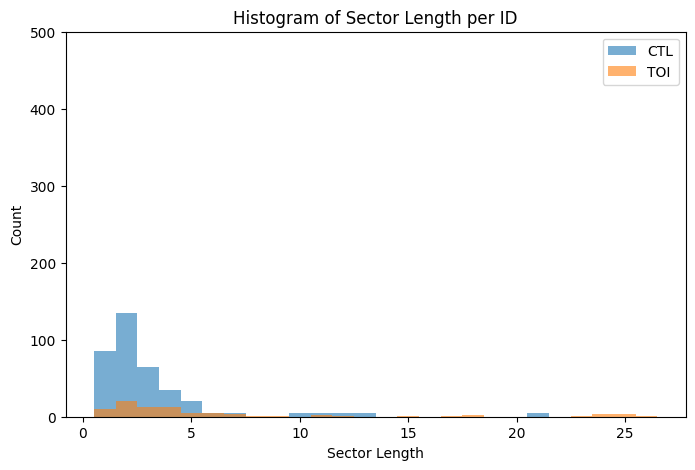

Number of TOIs with sector length 18: 1
Number of CTLs with sector length 18: 0


In [23]:
CTL_sectors = pd.read_csv("saved_sectors_info_CTL.csv")
print(CTL_sectors)
TOI_sectors = pd.read_csv("saved_sectors_info_TOI.csv")
plt.figure(figsize=(8, 5))
plt.hist(CTL_sectors['sector_length'], bins=np.arange(0.5, CTL_sectors['sector_length'].max()+1.5, 1), alpha=0.6, label='CTL')
plt.hist(TOI_sectors['sector_length'], bins=np.arange(0.5, TOI_sectors['sector_length'].max()+1.5, 1), alpha=0.6, label='TOI')
plt.xlabel('Sector Length')
plt.ylabel('Count')
plt.title('Histogram of Sector Length per ID')
plt.legend()
plt.ylim(0,500)
plt.show()

num_tois_sector18 = (TOI_sectors['sector_length'] == 26).sum()
print(f"Number of TOIs with sector length 18: {num_tois_sector18}")

num_clts_sector18 = (CTL_sectors['sector_length'] == 26).sum()
print(f"Number of CTLs with sector length 18: {num_clts_sector18}")

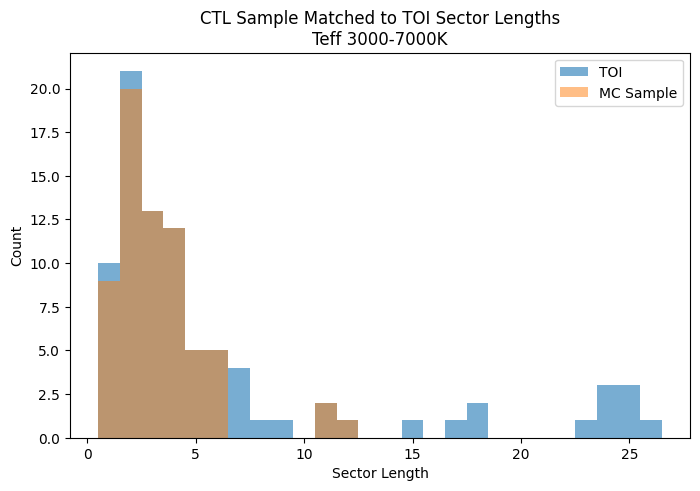

TOI ratio (20-26 / 0-7): 0.10, 8/78
CTL ratio (20-26 / 0-7): 0.00, 0/69


In [ ]:
# For each sector_length in TOI_sectors, randomly sample a CTL star with the same sector_length
np.random.seed(5)  # for reproducibility

sampled_ctl_indices = []
used_indices = set()
for sector_len in TOI_sectors['sector_length']:
    matches = CTL_sectors[(CTL_sectors['sector_length'] == sector_len) & (~CTL_sectors.index.isin(used_indices))]
    if not matches.empty:
        sampled_idx = matches.sample(1).index[0]
        sampled_ctl_indices.append(sampled_idx)
        used_indices.add(sampled_idx)

ctl_matched_sample = CTL_sectors.loc[sampled_ctl_indices]

# Define temperature range for histograms
teff_min = 3000  
teff_max = 7000

# Filter for the chosen Teff range
toi_temp_range = TOI_sectors[(TOI_sectors['teff'] >= teff_min) & (TOI_sectors['teff'] < teff_max)]
ctl_temp_range = ctl_matched_sample[(ctl_matched_sample['teff'] >= teff_min) & (ctl_matched_sample['teff'] < teff_max)]

plt.figure(figsize=(8, 5))
plt.hist(toi_temp_range['sector_length'], bins=np.arange(0.5, toi_temp_range['sector_length'].max()+1.5, 1), 
         alpha=0.6, label=f'TOI')
plt.hist(ctl_temp_range['sector_length'], bins=np.arange(0.5, ctl_temp_range['sector_length'].max()+1.5, 1), 
         alpha=0.5, label=f'MC Sample')

plt.xlabel('Sector Length')
plt.ylabel('Count')
plt.title(f'CTL Sample Matched to TOI Sector Lengths\nTeff {teff_min}-{teff_max}K')
plt.legend()
plt.show()

num_toi_20_26 = toi_temp_range[(toi_temp_range['sector_length'] >= 20) & (toi_temp_range['sector_length'] <= 26)].shape[0]
num_ctl_20_26 = ctl_temp_range[(ctl_temp_range['sector_length'] >= 20) & (ctl_temp_range['sector_length'] <= 26)].shape[0]



num_toi_0_7 = toi_temp_range[(toi_temp_range['sector_length'] >= 0) & (toi_temp_range['sector_length'] <= 7)].shape[0]
num_ctl_0_7 = ctl_temp_range[(ctl_temp_range['sector_length'] >= 0) & (ctl_temp_range['sector_length'] <= 7)].shape[0]

# Flip 0-5 and 20-25 in the ratio calculations
ratio_toi = num_toi_20_26 / num_toi_0_7 
ratio_ctl = num_ctl_20_26 / num_ctl_0_7 

print(f"TOI ratio (20-26 / 0-7): {ratio_toi:.2f}, {num_toi_20_26}/{num_toi_0_7}")
print(f"CTL ratio (20-26 / 0-7): {ratio_ctl:.2f}, {num_ctl_20_26}/{num_ctl_0_7}")




In [31]:
#ONLY RUN THIS CELL IF YOU WANT TO MODIFY stellar_params_CTL.csv to be cut down based on sector lengths
print(ctl_matched_sample)

# Save the matched CTL sample to multiple locations
ctl_matched_sample.to_csv("stellar_params_CTL.csv", index=False)
ctl_matched_sample.to_csv("../2_injection/stellar_params_CTL.csv", index=False)
ctl_matched_sample.to_csv("../2_injection/3_import_to_geryon/stellar_params_CTL.csv", index=False)
ctl_matched_sample.to_csv("../3_recovery_heatmaps/stellar_params_CTL.csv", index=False)

print(f"Saved control sample to stellar_params_CTL.csv")
print(f"Saved to ../2_injection/stellar_params_CTL.csv")
print(f"Saved to ../2_injection/3_import_to_geryon/stellar_params_CTL.csv")
print(f"Saved to ../3_recovery_heatmaps/stellar_params_CTL.csv")

              id  sector_length     tmag       RAD      MASS    teff
379  297823453.0            4.0  12.7443  0.223654  0.192935  3181.0
238  123013596.0            5.0  10.4910  0.297321  0.273564  3311.0
47   323959890.0            4.0  12.7998  0.264384  0.236586  3201.0
256  323196001.0            1.0  11.8604  0.278687  0.252499  3444.0
167   16773461.0            2.0  11.5519  0.304189  0.281402  3230.0
..           ...            ...      ...       ...       ...     ...
209  115117598.0            1.0  12.8745  0.225519  0.194870  3121.0
415  148050431.0            2.0  10.4434  0.304846  0.282154  3399.0
257  124815110.0            2.0  11.8249  0.275992  0.249483  3299.0
246  231459697.0            3.0  11.2684  0.267203  0.239702  3373.0
121   25374751.0            2.0  11.5526  0.237468  0.207424  3286.0

[81 rows x 6 columns]
Saved control sample to stellar_params_CTL.csv
Saved to ../2_injection/stellar_params_CTL.csv
Saved to ../2_injection/3_import_to_geryon/stellar_para